# Baseline v6 — EfficientNet-B4 + Label Smoothing + Focused Aug + K-Fold + Best-Model Classwise F1 + Ordered Submission (Gamma-only)
*Generated on 2025-11-04*


In [5]:

# === [설정/임포트] 공통 설정 및 경로, 하이퍼파라미터 ===
import os, random, cv2, numpy as np, pandas as pd, csv
from pathlib import Path
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
# from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
from datetime import date

DATA_CSV = Path("data/train.csv")
RAW_TRAIN_DIR = Path("data/train")
DATA_DIR = Path("data/train_sorted")
TEST_DIR = Path("data/test")
TEST_GAMMA_DIR = Path("data/test_gamma")
SUBMIT_SAMPLE = Path("submission.csv")
SUBMIT_DIR = Path("submission"); SUBMIT_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 384
N_SPLITS = 5
EPOCHS = 100
EARLY_STOP_PATIENCE = 10
BATCH_SIZE = 16
LR = 1e-4
SEED = 42
NUM_WORKERS = 4

MIXUP_ALPHA = 0.4
MIXUP_PROB = 0.0

NORM_MEAN = [0.5743, 0.5833, 0.5881]
NORM_STD  = [0.1896, 0.1869, 0.1850]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)


DEVICE: cuda


In [6]:

# === [전처리(선택)] CSV 기반 라벨 폴더 구성 ===
def build_class_folders_from_csv(csv_path=DATA_CSV, img_root=RAW_TRAIN_DIR, out_root=DATA_DIR):
    if not csv_path.exists():
        print(f"⚠️ CSV가 없습니다: {csv_path}"); return
    df = pd.read_csv(csv_path)
    out_root.mkdir(parents=True, exist_ok=True)
    missing = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc="CSV 기반 폴더 분류"):
        fname, label = str(row['ID']), str(row['target'])
        src = Path(img_root) / fname
        dst = Path(out_root) / label
        dst.mkdir(parents=True, exist_ok=True)
        if src.exists():
            dst_path = dst / fname
            if not dst_path.exists():
                try: dst_path.symlink_to(src.resolve()) if hasattr(Path, "symlink_to") else shutil.copy(src, dst_path)
                except Exception: shutil.copy(src, dst_path)
        else:
            missing += 1
    print(f"✅ 폴더 구성 완료: {out_root} (missing files: {missing})")
# build_class_folders_from_csv()


In [7]:

# === [테스트 전처리] 감마 보정(0.8)만 적용 (디노이즈 제거) ===
def adjust_gamma(image, gamma=0.8):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def preprocess_test_gamma(test_dir=TEST_DIR, out_dir=TEST_GAMMA_DIR, gamma=0.8):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    if not Path(test_dir).exists():
        print(f"⚠️ Test dir not found: {test_dir}"); return out_dir
    all_imgs = [p for p in Path(test_dir).rglob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".tiff",".webp")]
    if not all_imgs:
        print("⚠️ 테스트 이미지가 없습니다."); return out_dir
    for p in tqdm(all_imgs, desc="Gamma correcting test"):
        img = cv2.imread(str(p))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gamma_img = adjust_gamma(img, gamma=gamma)
        out_path = out_dir/p.name
        cv2.imwrite(str(out_path), cv2.cvtColor(gamma_img, cv2.COLOR_RGB2BGR))
    print("✅ Gamma corrected test set saved to:", out_dir)
    return out_dir

# TEST_GAMMA_DIR = preprocess_test_gamma(gamma=0.8)


In [8]:

# === [증강] 헷갈리는 클래스 구분력 강화를 위한 집중 증강 ===
def get_train_transform(img_size=512):
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    return A.Compose([
        A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.8, 1.0), p=0.7),
        A.Resize(height=img_size, width=img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=(-35, 35), p=0.6),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.GaussNoise(var_limit=(30.0, 120.0), per_channel=True, mean=0.0, p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.7),
        A.CoarseDropout(max_holes=10, max_height=20, max_width=20, p=0.7),
        A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        A.Normalize(mean=NORM_MEAN, std=NORM_STD),
        ToTensorV2(),
    ])

def get_valid_transform(img_size=512):
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    return A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=NORM_MEAN, std=NORM_STD),
        ToTensorV2(),
    ])


In [9]:

# === [Dataset] 이미지 경로/라벨 기반 PyTorch Dataset ===
class ImageDatasetFromPaths(Dataset):
    def __init__(self, img_paths, labels=None, is_train=True, img_size=512):
        self.img_paths = img_paths
        self.labels = labels
        self.tf = get_train_transform(img_size) if is_train else get_valid_transform(img_size)

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        p = self.img_paths[idx]
        img = cv2.imread(str(p))
        if img is None:
            img = np.ones((512, 512, 3), dtype=np.uint8) * 255
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = self.tf(image=img)["image"]
        y = -1 if self.labels is None else int(self.labels[idx])
        return x, y, str(p)


In [10]:

# === [로딩] DATA_DIR에서 이미지 경로/라벨 불러오기 ===
def load_paths_labels_from_dir(root=Path("data/train_sorted")):
    classes = sorted([d.name for d in Path(root).iterdir() if d.is_dir()])
    if not classes:
        raise FileNotFoundError(f"클래스 폴더가 없습니다. 먼저 build_class_folders_from_csv()로 {root} 구성 필요.")
    class_to_idx = {c:i for i,c in enumerate(classes)}
    img_paths, labels = [], []
    for c in classes:
        for p in sorted((Path(root)/c).iterdir()):
            if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".tiff",".webp"):
                img_paths.append(p); labels.append(class_to_idx[c])
    return img_paths, labels, classes, class_to_idx


In [11]:

# === [모델/유틸] EfficientNet-B4 + Label Smoothing + (옵션) Mixup ===
def create_model(num_classes):
    m = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    in_features = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_features, num_classes)
    return m

def get_optimizer(model):
    return torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

class EarlyStopping:
    def __init__(self, patience=10, mode="max", delta=1e-6):
        self.patience = patience; self.mode=mode; self.delta=delta
        self.best=None; self.counter=0; self.early_stop=False
    def step(self, metric):
        if self.best is None: self.best=metric; return False
        improve = (metric - self.best) > self.delta if self.mode=="max" else (self.best - metric) > self.delta
        if improve: self.best=metric; self.counter=0
        else:
            self.counter+=1
            if self.counter>=self.patience: self.early_stop=True
        return self.early_stop

def get_criterion(label_smoothing=0.1, class_weights=None):
    if class_weights is not None:
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    return nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [12]:

# === [루프] 한 epoch 학습/검증 ===
def train_one_epoch(model, loader, optimizer, criterion, device=DEVICE):
    model.train(True)
    total_loss = 0.0
    all_preds, all_targets = [], []
    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        use_mixup = (np.random.rand() < MIXUP_PROB)
        if use_mixup and MIXUP_ALPHA > 0:
            xm, y_a, y_b, lam = mixup_data(x, y, alpha=MIXUP_ALPHA)
            logits = model(xm)
            loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_targets.extend(y_a.detach().cpu().numpy().tolist())
        else:
            logits = model(x)
            loss = criterion(logits, y)
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_targets.extend(y.detach().cpu().numpy().tolist())
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(loader.dataset)
    macro_f1 = f1_score(all_targets, all_preds, average="macro")
    return avg_loss, macro_f1

def validate_one_epoch(model, loader, criterion, device=DEVICE):
    model.train(False)
    total_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_targets.extend(y.detach().cpu().numpy().tolist())
    avg_loss = total_loss / len(loader.dataset)
    macro_f1 = f1_score(all_targets, all_preds, average="macro")
    per_class_f1 = f1_score(all_targets, all_preds, average=None)
    return avg_loss, macro_f1, per_class_f1, np.array(all_targets), np.array(all_preds)


In [13]:

# === [학습] Stratified K-Fold 학습 + 베스트 모델 리포트 ===
def kfold_train(img_paths, labels, classes, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    histories = []
    best_fold_ckpts = []
    classwise_f1_all_folds = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(img_paths, labels), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")
        tr_imgs = [img_paths[i] for i in tr_idx]
        va_imgs = [img_paths[i] for i in va_idx]
        tr_labels = [labels[i] for i in tr_idx]
        va_labels = [labels[i] for i in va_idx]

        tr_loader = DataLoader(ImageDatasetFromPaths(tr_imgs, tr_labels, True, IMG_SIZE),
                               batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        va_loader = DataLoader(ImageDatasetFromPaths(va_imgs, va_labels, False, IMG_SIZE),
                               batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        model = create_model(num_classes=len(classes)).to(DEVICE)
        optimizer = get_optimizer(model)
        scheduler = get_scheduler(optimizer)
        criterion = get_criterion(label_smoothing=0.1)
        stopper = EarlyStopping(patience=EARLY_STOP_PATIENCE, mode="max")

        hist = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}
        best_val_f1 = -1.0
        ckpt_path = Path(f"best_efficientnet_b4_fold{fold}.pt")

        for epoch in range(1, EPOCHS+1):
            train_loss, train_f1 = train_one_epoch(model, tr_loader, optimizer, criterion, DEVICE)
            val_loss, val_f1, _, _, _ = validate_one_epoch(model, va_loader, criterion, DEVICE)
            scheduler.step()

            hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)
            hist["train_f1"].append(train_f1);     hist["val_f1"].append(val_f1)
            print(f"Epoch {epoch:03d}/{EPOCHS} | train_loss {train_loss:.4f} val_loss {val_loss:.4f} | "
                  f"train_f1 {train_f1:.4f} val_f1 {val_f1:.4f}")

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save({"model": model.state_dict(),
                            "num_classes": len(classes),
                            "classes": classes,
                            "img_size": IMG_SIZE}, ckpt_path)

            if stopper.step(val_f1):
                print(f"Early stopping at epoch {epoch} (no improvement for {EARLY_STOP_PATIENCE} epochs).")
                break

        histories.append(hist)
        best_fold_ckpts.append((best_val_f1, ckpt_path))

        # Fold 종료 후: 베스트 모델 로드하여 클래스별 F1 리포트 1회 출력
        best_model, _, _ = load_model_from_ckpt(ckpt_path)
        final_val_loader = DataLoader(ImageDatasetFromPaths(va_imgs, va_labels, False, IMG_SIZE),
                                      batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        all_true, all_pred = [], []
        best_model.eval()
        with torch.no_grad():
            for x, y, _ in final_val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                preds = torch.argmax(best_model(x), dim=1)
                all_true.extend(y.cpu().numpy())
                all_pred.extend(preds.cpu().numpy())

        print("\n=== Classification Report (Best Model of Fold) ===")
        print(classification_report(all_true, all_pred, target_names=classes, digits=4))

        fold_per_class_f1 = f1_score(all_true, all_pred, average=None)
        classwise_f1_all_folds.append(fold_per_class_f1)

    classwise_f1_all_folds = np.stack(classwise_f1_all_folds, axis=0)
    classwise_f1_mean = classwise_f1_all_folds.mean(axis=0)
    print("\n=== 클래스별 F1 (평균, 검증) ===")
    for i, c in enumerate(classes):
        print(f"{c}: {classwise_f1_mean[i]:.4f}")

    return histories, best_fold_ckpts, classwise_f1_mean


In [14]:

# === [시각화] F1/Loss 곡선 ===
def plot_metric(histories, key, title):
    plt.figure(figsize=(8,5))
    for i, hist in enumerate(histories, 1):
        plt.plot(hist[key], label=f"Fold{i}")
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(key); plt.legend(); plt.grid(True); plt.show()


In [15]:

# === [추론/제출] 베스트 체크포인트로 추론하고, submission.csv의 ID 순서에 맞춰 저장 (감마 폴더 사용) ===
def load_model_from_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    m = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    in_features = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_features, ckpt["num_classes"])
    m.load_state_dict(ckpt["model"]); m.to(DEVICE); m.eval()
    return m, ckpt["classes"], ckpt["img_size"]

def infer_to_submission(ckpt_path, submission_csv=Path("submission.csv"), test_dir=TEST_GAMMA_DIR, model_name="efficientnet_b4"):
    sub_df = pd.read_csv(submission_csv)
    if "ID" not in sub_df.columns:
        raise ValueError("제출 샘플 CSV에 'ID' 열이 필요합니다.")

    model, classes, img_size = load_model_from_ckpt(ckpt_path)

    test_dir = Path(test_dir)
    if not test_dir.exists():
        raise FileNotFoundError(f"Test dir not found: {test_dir} — 먼저 preprocess_test_gamma()를 실행하세요.")

    tf = A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=NORM_MEAN, std=NORM_STD),
        ToTensorV2(),
    ])

    preds_map = {}
    with torch.no_grad():
        for row in tqdm(sub_df.itertuples(index=False), total=len(sub_df), desc="Infer by submission order"):
            fn = getattr(row, "ID")
            p = test_dir / fn
            if not p.exists():
                cand = list(test_dir.rglob(fn))
                if not cand:
                    preds_map[fn] = classes[0]
                    continue
                p = cand[0]
            img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
            x = tf(image=img)["image"].unsqueeze(0).to(DEVICE)
            logits = model(x); pred = torch.argmax(logits, dim=1).item()
            preds_map[fn] = classes[pred]

    out_df = pd.DataFrame({"ID": sub_df["ID"], "target": sub_df["ID"].map(preds_map)})
    out_path = Path("submission") / f"{model_name}_{date.today().isoformat()}.csv"
    out_df.to_csv(out_path, index=False)
    print("Saved submission:", out_path)
    return out_path


In [16]:
torch.cuda.empty_cache()


===== Fold 1/5 =====
Epoch 001/100 | train_loss 2.7577 val_loss 2.5902 | train_f1 0.2088 val_f1 0.4915
Epoch 002/100 | train_loss 2.2300 val_loss 1.6332 | train_f1 0.3838 val_f1 0.6112
Epoch 003/100 | train_loss 1.6196 val_loss 1.2662 | train_f1 0.5611 val_f1 0.6721
Epoch 004/100 | train_loss 1.3306 val_loss 1.0636 | train_f1 0.6909 val_f1 0.7748
Epoch 005/100 | train_loss 1.2023 val_loss 0.9543 | train_f1 0.7220 val_f1 0.8469
Epoch 006/100 | train_loss 1.1375 val_loss 0.9253 | train_f1 0.7562 val_f1 0.8447
Epoch 007/100 | train_loss 1.0668 val_loss 0.8948 | train_f1 0.7789 val_f1 0.8719
Epoch 008/100 | train_loss 1.0310 val_loss 0.8813 | train_f1 0.8061 val_f1 0.8657
Epoch 009/100 | train_loss 0.9853 val_loss 0.8713 | train_f1 0.8192 val_f1 0.8416
Epoch 010/100 | train_loss 0.9684 val_loss 0.8437 | train_f1 0.8232 val_f1 0.8639
Epoch 011/100 | train_loss 0.9325 val_loss 0.8228 | train_f1 0.8376 val_f1 0.8769
Epoch 012/100 | train_loss 0.9165 val_loss 0.8192 | train_f1 0.8353 val_f1 0

/tmp/ipykernel_320813/1195152329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)



=== Classification Report (Best Model of Fold) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    1.0000    1.0000        10
          10     0.9091    1.0000    0.9524        20
          11     1.0000    0.9000    0.9474        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    0.9286    0.9630        14
          14     0.8333    0.5000    0.6250        10
          15     1.0000    1.0000    1.0000        20
          16     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     0.5185    0.7000    0.5957        20
           4     0.9048    0.9500    0.9268        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     0.6471    0.5500    0.5946        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.

/tmp/ipykernel_320813/1195152329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)



=== Classification Report (Best Model of Fold) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    1.0000    1.0000         9
          10     1.0000    1.0000    1.0000        20
          11     1.0000    1.0000    1.0000        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    0.9333    0.9655        15
          14     0.8571    0.6000    0.7059        10
          15     1.0000    1.0000    1.0000        20
          16     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     0.7727    0.8500    0.8095        20
           4     0.8261    0.9500    0.8837        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     0.7368    0.7000    0.7179        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.

/tmp/ipykernel_320813/1195152329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)



=== Classification Report (Best Model of Fold) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    1.0000    1.0000         9
          10     0.9524    1.0000    0.9756        20
          11     1.0000    0.9000    0.9474        20
          12     1.0000    1.0000    1.0000        20
          13     0.9375    1.0000    0.9677        15
          14     0.7000    0.7000    0.7000        10
          15     1.0000    1.0000    1.0000        20
          16     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     0.7647    0.6500    0.7027        20
           4     0.8571    0.9000    0.8780        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     0.6364    0.7000    0.6667        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.

/tmp/ipykernel_320813/1195152329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)



=== Classification Report (Best Model of Fold) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     0.9000    1.0000    0.9474         9
          10     1.0000    1.0000    1.0000        20
          11     1.0000    1.0000    1.0000        20
          12     0.9524    1.0000    0.9756        20
          13     1.0000    1.0000    1.0000        15
          14     0.8750    0.7000    0.7778        10
          15     1.0000    1.0000    1.0000        20
          16     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     0.6522    0.7500    0.6977        20
           4     0.8947    0.8500    0.8718        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     0.7778    0.7000    0.7368        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.

/tmp/ipykernel_320813/1195152329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)



=== Classification Report (Best Model of Fold) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    1.0000    1.0000         9
          10     1.0000    0.9500    0.9744        20
          11     0.9524    1.0000    0.9756        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    1.0000    1.0000        15
          14     1.0000    0.7000    0.8235        10
          15     1.0000    1.0000    1.0000        20
          16     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     0.6071    0.8500    0.7083        20
           4     0.9500    0.9500    0.9500        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     0.6667    0.5000    0.5714        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.

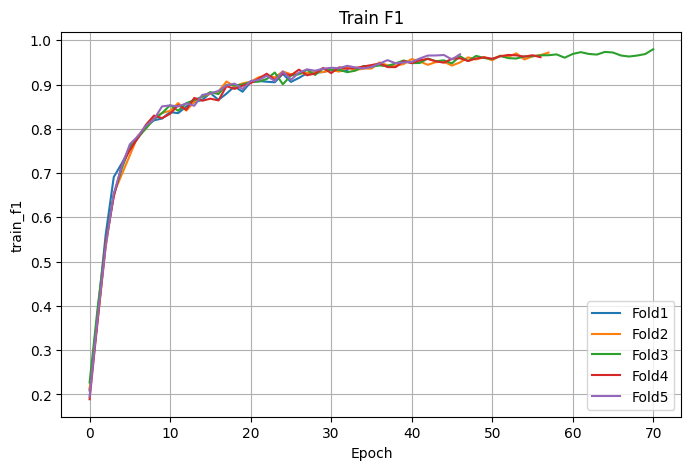

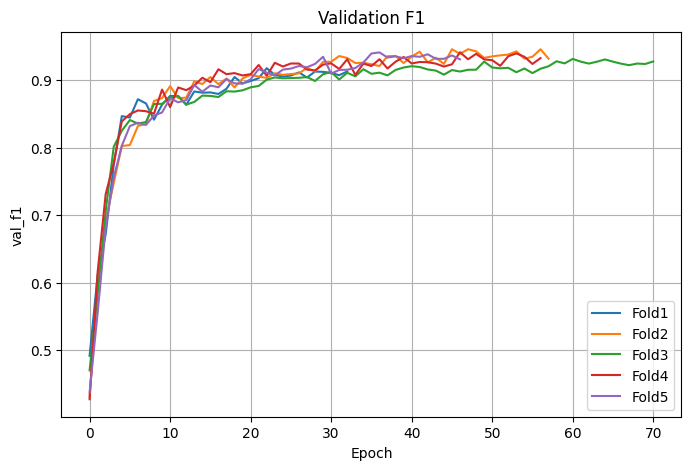

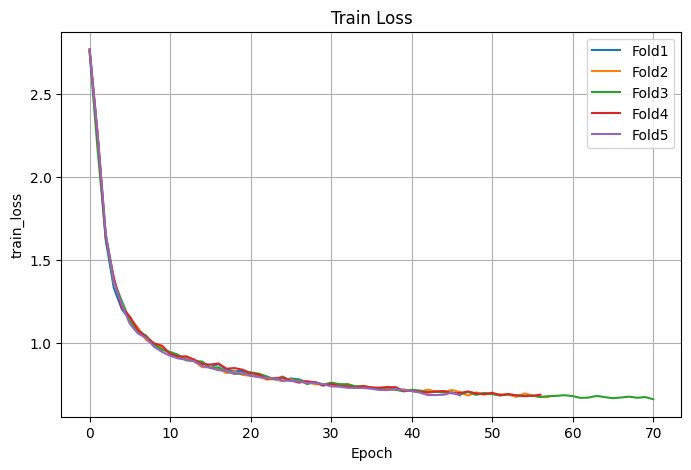

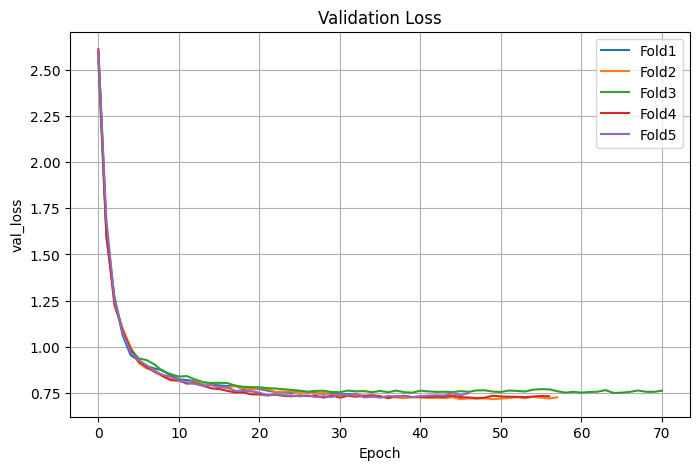

In [17]:
img_paths, labels, classes, _ = load_paths_labels_from_dir()
histories, best_ckpts, classwise_f1_mean = kfold_train(img_paths, labels, classes)

plot_metric(histories, "train_f1", "Train F1")
plot_metric(histories, "val_f1",   "Validation F1")
plot_metric(histories, "train_loss","Train Loss")
plot_metric(histories, "val_loss",  "Validation Loss")

In [19]:
# 성능 최고 checkpoint 선택
best_ckpt = sorted(best_ckpts, key=lambda x: x[0], reverse=True)[0][1]

# 사용자가 제공한 submission.csv의 ID 순서대로 예측 & 저장
infer_to_submission(best_ckpt, submission_csv=Path("data/sample_submission.csv"),
                    test_dir=TEST_GAMMA_DIR, model_name="efficientnet_b4_2")
# => submission/efficientnet_b4_YYYY-MM-DD.csv (헤더: ID,target)

/tmp/ipykernel_320813/1195152329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)


Infer by submission order:   0%|          | 0/3140 [00:00<?, ?it/s]

Saved submission: submission/efficientnet_b4_2_2025-11-04.csv


PosixPath('submission/efficientnet_b4_2_2025-11-04.csv')